In [1]:
from cuda_code.final.test_functions import *
import numpy as np
from cuda_code.final.benchmark import *
from cuda_code.final.monolithic import GSO as PGSO
import matplotlib.pyplot as plt
import seaborn as sns

# Time profile between PSO and GSO (NON - PARALLEL) and PARALLEL GSO

Construct particle class

In [2]:
#dependencies
import random
import math
import copy # for array copying
import sys

class Particle:
    def __init__(self,x0, num_dimensions):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual
        self.num_dimensions = num_dimensions
        
        for i in range(0, self.num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0, self.num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0, self.num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]

# PSO

In [3]:
def PSO(costFunc,bounds,maxiter, swarm_init):
    global num_dimensions

    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = [Particle(position, num_dimensions) for position in swarm_init]
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        i+=1

    # print final results
    #print ('\n')
    #print (pos_best_g,' , ', err_best_g)
    return pos_best_g, err_best_g

In [5]:
# GLOBAL SEttiNGS
initial=[5,5]                             # initial starting location [x1,x2...]
bounds = [[-1000, 1000], [-1000, 1000]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 75
max_iter = 1500

def test_PSO(M, bounds, num_particles, max_iter, costfunc):
    subswarm_bests = []
    for i in range(M):
        swarm_init = [np.random.uniform(-10,10, 2) for _ in range(num_particles)]
        subswarm_best,_ = PSO(costfunc,bounds,max_iter, swarm_init=swarm_init)
        subswarm_bests.append(subswarm_best)
    best_position, best_error = PSO(costfunc, bounds, max_iter, swarm_init=subswarm_bests)
    return best_position, best_error

In [12]:
%timeit test_PSO(5, bounds, num_particles, max_iter, rastrigin)

12 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot cpu usage graph for PSO
Y - axis is cpu usage in %

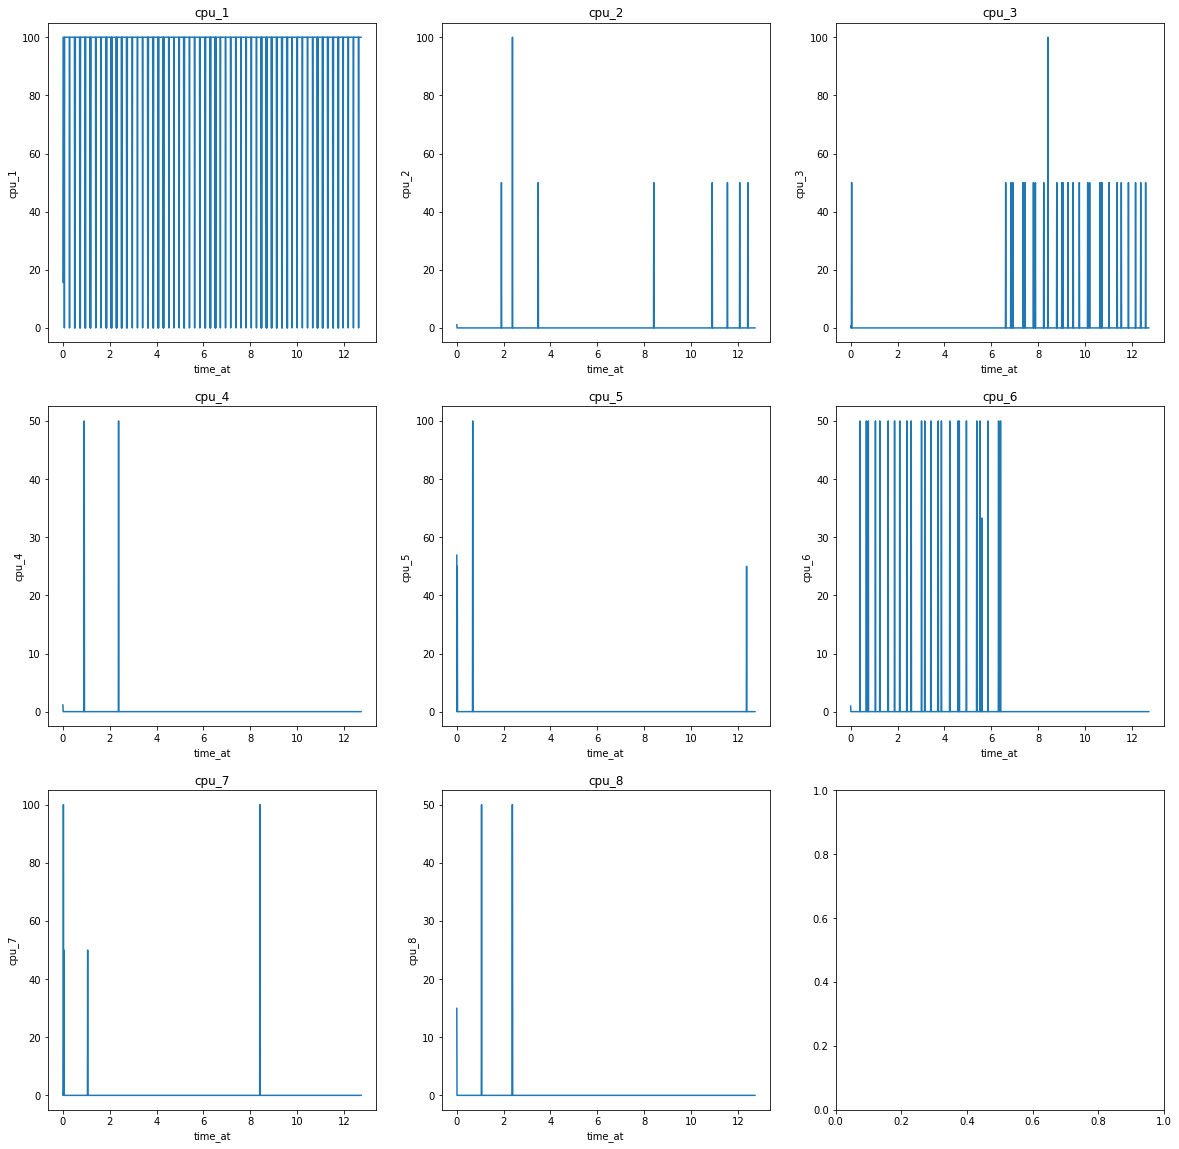

In [6]:
cpu_percent, time_at, top_prcnt = monitor(test_PSO, bounds, num_particles, max_iter, rastrigin, 5)
multiple_cpu_plot(top_prcnt, time_at)

# GSO
galactic swarm optimization without parallel

In [4]:
def GSO(M, bounds, num_particles, max_iter, costfunc):
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1] 
    for i in range(M):
        #initial= np.random.uniform(-10,10, 2)               # initial starting location [x1,x2...]         
        swarm_init = [np.random.uniform(lb, ub, dims) for _ in range(num_particles)]
        subswarm_best,_ = PSO(costfunc,bounds,max_iter, swarm_init=swarm_init)
        subswarm_bests.append(subswarm_best)
    best_position, best_error = PSO(costfunc, bounds, max_iter, swarm_init=subswarm_bests)
    return best_position, best_error

In [10]:
%timeit GSO(5, bounds, num_particles, max_iter, rastrigin)

17 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot cpu usage graph for GSO

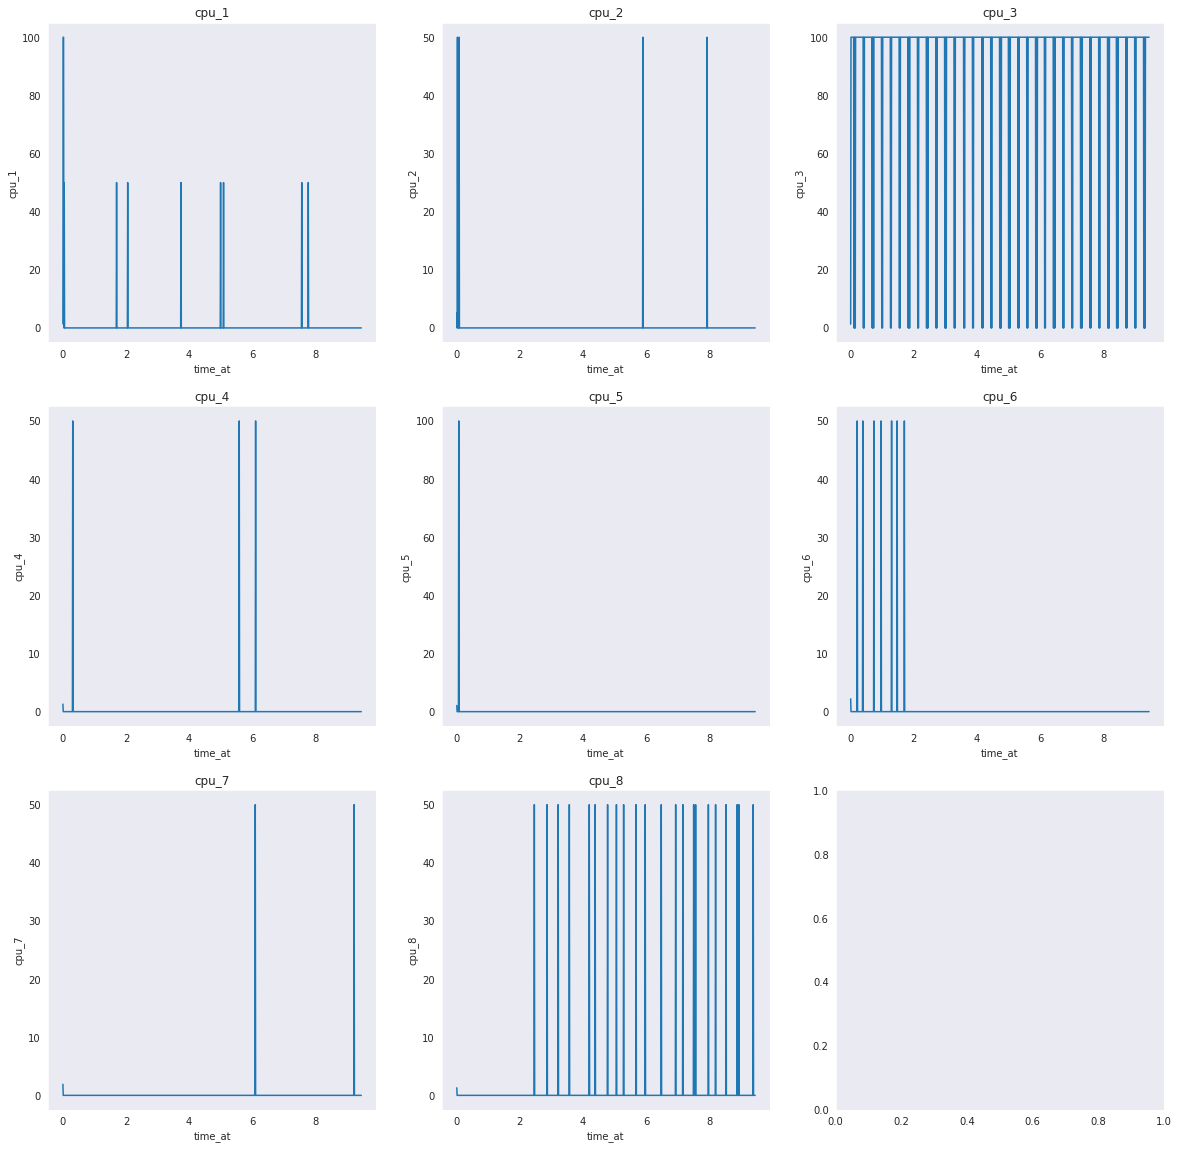

In [12]:
cpu_percent, time_at, top_prcnt = monitor(GSO, bounds, num_particles, max_iter, rastrigin, 5)
multiple_cpu_plot(top_prcnt, time_at)

# Parallelized GSO

In [16]:
%timeit PGSO(1, bounds, num_particles, max_iter, rastrigin)

15.9 s ± 3.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


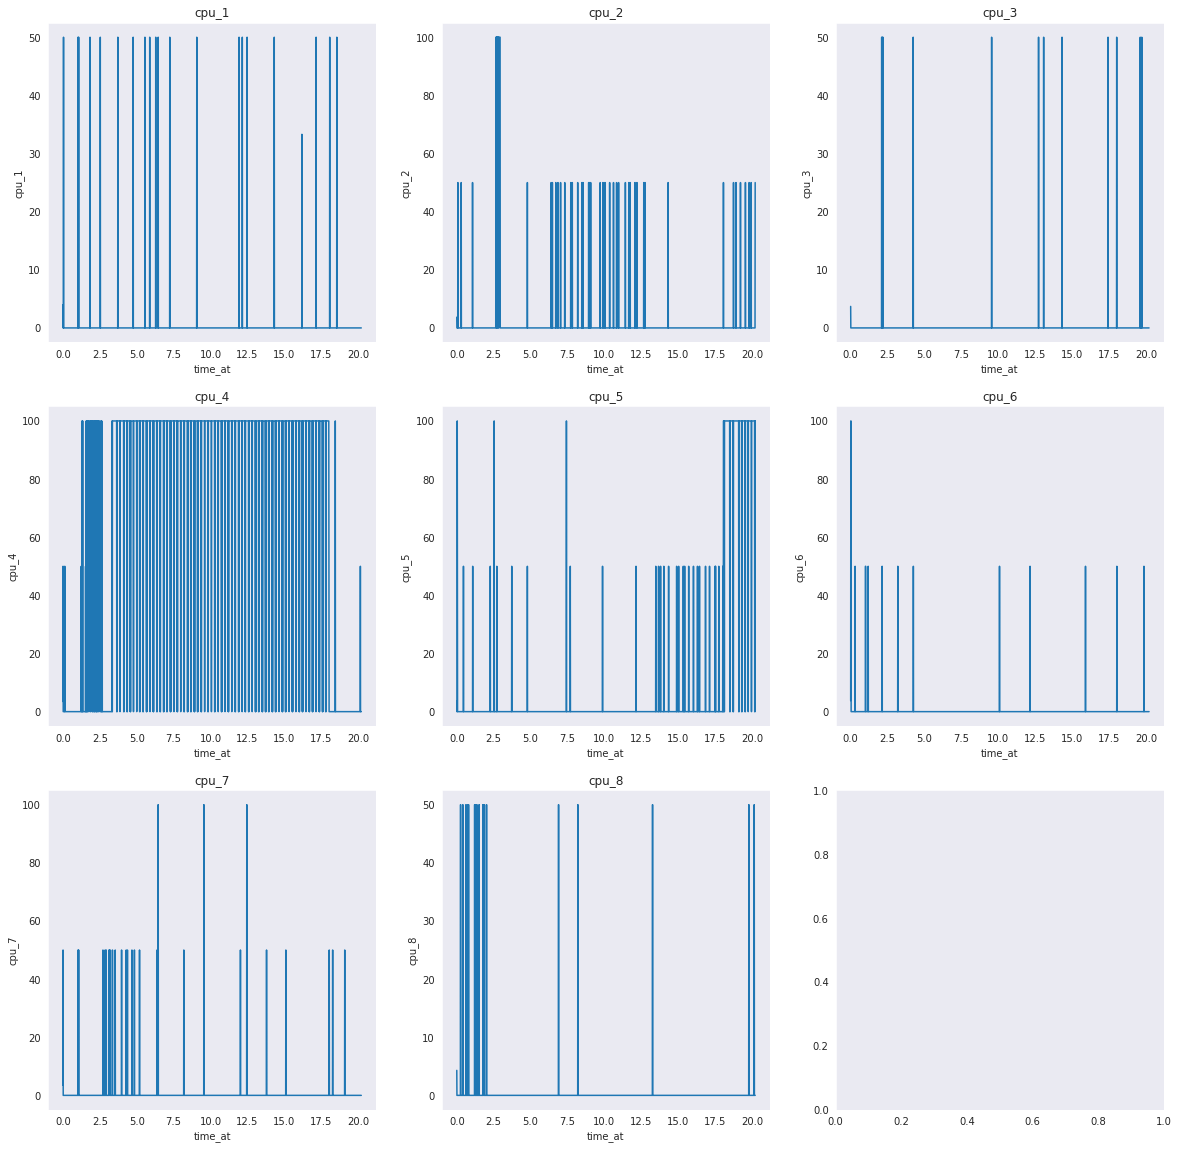

In [15]:
# 1 cpu test
cpu_percents, time_at, top_prcnt = monitor(PGSO, bounds, num_particles, max_iter, rastrigin, 1)
multiple_cpu_plot(top_prcnt, time_at)

# Testing All benchmark functions with PGSO spwaning 8 processes

In [9]:
list_of_benchmark_functions = [sphere, rosen, rastrigin, griewank, zakharov, nonContinuousRastrigin]
string_list = ["sphere", "rosen", "rastrigin", "griewank", "zakharov", "nonContinuousRastrigin"]

bounds = [[-100, 100], [-100, 100]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 20
max_iter = 500

for costfun, stre in zip(list_of_benchmark_functions, string_list):
    best_pos, best_err = PGSO(8, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [0.999963   0.99992281]  best error:  1.7521811060274705e-09
rosen  best position:  [1. 1.]  best error:  1.262177448353619e-29
rastrigin  best position:  [0.99999276 0.99998553]  best error:  5.2522347151565965e-11
griewank  best position:  [1.00000143 1.00000286]  best error:  2.0538605158670134e-12
zakharov  best position:  [0.99948174 0.99900123]  best error:  2.8253814587149963e-07
nonContinuousRastrigin  best position:  [0.99993307 0.99986582]  best error:  4.508960414993844e-09


In [4]:
%load_ext line_profiler
%lprun PGSO(8, bounds, num_particles, max_iter, costfun)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

# Testing All Benchmark functions with GSO (NON - PARALLEL)

In [14]:
for costfun, stre in zip(list_of_benchmark_functions, string_list):
    if stre == 'rosen':
        continue
    best_pos, best_err = GSO(5, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [1.1670985554099485e-58, 1.4275821347627206e-52]  best error:  2.0379907514950487e-104
rastrigin  best position:  [-3.605039314054965e-09, -1.0775757012378756e-09]  best error:  0.0
griewank  best position:  [-3.140022639822862, 4.438444483319959]  best error:  0.007396040334115006
zakharov  best position:  [2.1101001147201805e-53, -2.027421846437707e-54]  best error:  5.220055597470466e-106
nonContinuousRastrigin  best position:  [-1.0421392513929151e-09, 6.8462017553291e-10]  best error:  0.0


# Testing ALL Benchmark functions with PSO

In [16]:
for costfun, stre in zip(list_of_benchmark_functions, string_list):
    if stre == 'rosen':
        continue
    best_pos, best_err = test_PSO(5, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [-1.024196238731495e-53, -2.1984090453300982e-54]  best error:  1.0973079587376335e-106
rastrigin  best position:  [2.320087337061599e-09, 1.5157624522447429e-09]  best error:  0.0
griewank  best position:  [-3.140022638811446, -4.438444471913139]  best error:  0.007396040334115006
zakharov  best position:  [-1.662868067918397e-55, 6.4613246215642115e-56]  best error:  3.2169540424675615e-110
nonContinuousRastrigin  best position:  [1.0687980779402988e-09, 4.0402410521503243e-10]  best error:  0.0


In [19]:
!numba --annotate-html gail.html ./cuda_code/final/monolithic.py

In [7]:
bounds = [[-1000, 1000], [-1000, 1000]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 50
max_iter = 1000

GSO_time = %timeit -o GSO(5, bounds, num_particles, max_iter, rastrigin)

6.76 s ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
PGSO_time = %timeit -o PGSO(1, bounds, num_particles, max_iter, rastrigin)

5.75 s ± 975 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
TS_GSO = GSO_time.average

TP = list()
TP.append(PGSO_time.average)

speedup = list()
speedup.append(TS_GSO/TP[0])

In [10]:
PGSO_time_2 = %timeit -o PGSO(2, bounds, num_particles, max_iter, rastrigin)
TP_2 = PGSO_time_2.average
TP.append(TP_2)
speedup.append(TS_GSO/TP_2)

7.75 s ± 626 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
PGSO_time_4 = %timeit -o PGSO(4, bounds, num_particles, max_iter, rastrigin)
TP_4 = PGSO_time_4.average
TP.append(TP_4)
speedup.append(TS_GSO/TP_4)

13.8 s ± 788 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
PGSO_time_6 = %timeit -o PGSO(6, bounds, num_particles, max_iter, rastrigin)
TP_6 = PGSO_time_6.average
TP.append(TP_6)
speedup.append(TS_GSO/TP_6)

20.1 s ± 934 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
PGSO_time_8 = %timeit -o PGSO(8, bounds, num_particles, max_iter, rastrigin)
TP_8 = PGSO_time_8.average
TP.append(TP_8)
speedup.append(TS_GSO/TP_8)

27 s ± 3.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


[HTML](file:///gail.html)

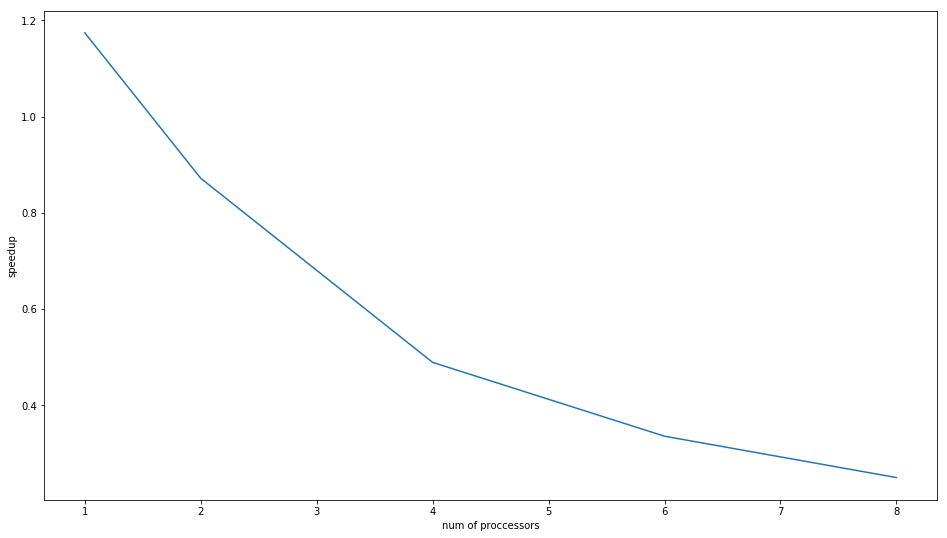

In [18]:
%matplotlib inline
plt.figure(figsize=(16,9))
ax = plt.gca()
ax.set_xlabel('num of proccessors')
ax.set_ylabel('speedup')
sns.lineplot(x=[1,2,4,6,8], y=speedup)